# Application of the Linear Interaction Energy Method to Nitric Oxide Synthase Structure Based Inhibitor Design

## Import packages

In [4]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from scipy.stats import bootstrap
import plotly.express as px
from matplotlib.ticker import MaxNLocator

In [5]:
# Function for performing regression and return values of alpha beta and gamma
def fitterlm(var1,var2,data):
    # Assume you have independent variables X and a dependent variable y
    X = np.array([var1,var2]).T
    y = data
    # Create an instance of the LinearRegression class
    reg = LinearRegression()
    # Fit the model to the data
    dgfit = reg.fit(X, y)
    [alpha,beta,gamma] = dgfit.coef_[0],dgfit.coef_[1],dgfit.intercept_
    return alpha,beta,gamma
#boot
def bootstrapper(data, sample_size, rounds):
    """
    Function for performing bootstrapping.

    Parameters:
    - data: DataFrame containing the data for bootstrapping.
    - sample_size: Number of samples to be selected in each bootstrap iteration.
    - rounds: Number of bootstrap rounds to perform.

    Returns:
    - dataset: DataFrame containing the bootstrapped estimates of the coefficients.
    """
    
    # Initialize an array to store the bootstrapped estimates
    out = np.zeros([rounds, 3])  # 3 columns for alpha, beta, gamma
    dups_distribution = [] # distribution of duplicates in bootstrap samples
    # Perform bootstrapping for the specified number of rounds
    for i in np.arange(rounds):
        # Generate a bootstrap sample by sampling with replacement from the original data
        df_bootstrap_sample = data[['dGexp', 'EEL', 'VDW']].sample(n=sample_size, replace=True)
        dups_distribution.append(df_bootstrap_sample.duplicated().sum())
        # Extract the bootstrap sample data into separate arrays
        dGexp = df_bootstrap_sample['dGexp'].to_numpy()
        eel = df_bootstrap_sample['EEL'].to_numpy()
        vdw = df_bootstrap_sample['VDW'].to_numpy()
        
        # Fit a linear model to the bootstrap sample and store the coefficients
        out[i] = fitterlm(eel, vdw, dGexp)
    
    # Create a DataFrame from the bootstrapped coefficient estimates
    dataset = pd.DataFrame({'alpha': out[:, 0], 'beta': out[:, 1], 'gamma': out[:, 2]})
    
    # Drop duplicate rows, if any
    dataset = dataset.drop_duplicates()
    
    # Return the DataFrame containing the bootstrapped estimates
    return dataset, np.array(dups_distribution)


def histoplot(dataset, bins,save=False,fname=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
    fig.tight_layout()
    
    # Define the distribution to fit (e.g., normal distribution)
    dist = norm
    
    # Fit and overlay the distribution on each histogram
    for ax, column,name in zip([ax1, ax2, ax3], ['alpha', 'beta', 'gamma'], ['α','β','γ']):
        data = dataset[column]
        ax.hist(data, bins=bins, color='k')
        mean, std_dev = dist.fit(data)
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        y = dist.pdf(x, mean, std_dev)
        ax.plot(x, y * len(data) * np.diff(ax.hist(data, bins=bins)[1])[0], color='r', linewidth=2)
        
        ax.axvline(data.mean(), color='k', linestyle='dashed', linewidth=2)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        ax.xaxis.set_tick_params(labelsize=14, width=1,direction='in')
        ax.yaxis.set_tick_params(labelsize=14, width=1,direction='in')
        ax.set_xlabel(name, fontsize=16, fontweight='regular')
        ax.xaxis.label.set_color('k')
        ax.yaxis.label.set_color('k')
        # formatting
        #plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
        plt.gca().yaxis.set_major_locator(MaxNLocator(prune='lower'))
        plt.subplots_adjust(bottom=0.25)
        
        if ax == ax1:
            ax.set_ylabel('Counts', fontsize=16, fontweight='regular')
        
        if save == True:
        
            # Save as PNG
            plt.savefig('figure_histoplot_%s.png' % fname, dpi=300)

            # Save as SVG
            plt.savefig('figure_histoplot_%s.svg' % fname , dpi=300)

    plt.show()

# Example usage:
# histoplot(dataset, bins=20, alpha=0.5)

#### Testing our simplified method using Eq. 5, we utilized the data from Tables 2 and 3 of Zhou et al. to compare with their data.
#### Eq. 5 $\Delta G_{\text{LIE}} = \alpha*(\Delta \text{VdW}_{b-f})+\beta*(\Delta \text{EEL}_{b-f}) + \gamma$

In [6]:

# Experimental data
delG_exp = np.array([-7.32, -7.73, -9.2, -8.06, -10.01, -12.16, -8.03, -5.43, -10.96, -11.24,
                     -11.89, -9.93, -6.52, -5.78, -9.35, -11.19, -12.16, -11.68, -5.11, -8.4])

# Data from Zhao 2001 paper
delG_Zhao = np.array([-7.73, -9.01, -8.56, -7.24, -9.82, -13.45, -7.87, -6.06, -10.2, -10.2,
                      -9.31, -8.49, -7.62, -7.15, -10.67, -10.77, -11.25, -11.85, -5.53, -9.59])

# Fit to Zhao data
f, residuals, rank, singular_values, rcond = np.polyfit(delG_exp, delG_Zhao, 1, full=True)
R2_zhao = 1 - residuals / np.linalg.norm(delG_Zhao - np.mean(delG_Zhao)) ** 2

# Load data from CSV file
mmgbsa_val = pd.read_csv('mmgbsa_vals_4fit.csv')

# Data workup
mmgbsa_val['U Sum'] = mmgbsa_val['Urx free'] + mmgbsa_val['Ucav free']
mmgbsa_val['totEEL'] = mmgbsa_val['EEL b'] + 2 * mmgbsa_val['Urx b'] - 2 * mmgbsa_val['U Sum']

# coefficients
a = 0.302727
b = 0.291872
g = 3.72266

liefit = a * mmgbsa_val['totEEL'] + b * mmgbsa_val['VDW bound'] + g

# Fit to our data
f1, residuals1, rank1, singular_values1, rcond1 = np.polyfit(delG_exp, liefit, 1, full=True)
R2_tlp = 1 - residuals1 / np.linalg.norm(liefit - np.mean(liefit)) ** 2


## Figure 1

The R² for this fit is 0.778. See figure below.


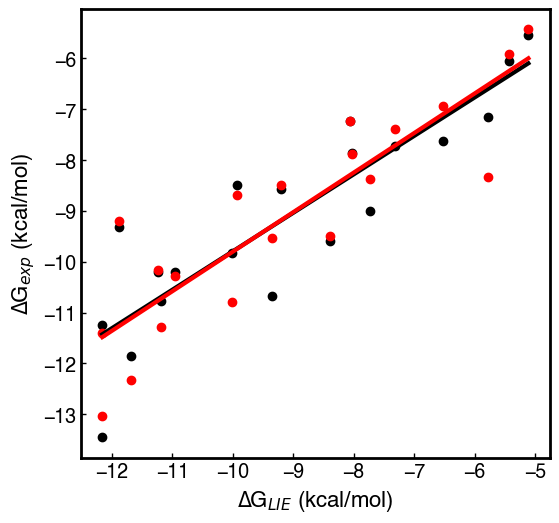

In [7]:
# Plotting
plt.rcParams['font.family'] = 'Helvetica'
fig1 = plt.figure(1, figsize=(6.25, 5.75))
ax1 = fig1.gca()
ax1.scatter(mmgbsa_val['dGexp'], mmgbsa_val['dGzhao'], marker='o', facecolors='k', edgecolors='k', label='Zhao')
ax1.scatter(mmgbsa_val['dGexp'], liefit, marker='o', color='r', label='This Work')
x = np.linspace(min(delG_exp), max(delG_exp))
ax1.plot(x, np.polyval(f, x), 'k', linewidth=3, label='Fit Zhao')
ax1.plot(x, np.polyval(f1, x), 'r', linewidth=3, label='Fit LIE')

#ax1.legend()

ax1.spines['top'].set_linewidth(2)
ax1.spines['right'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.xaxis.set_tick_params(labelsize=14, width=1,direction='in')
ax1.yaxis.set_tick_params(labelsize=14, width=1,direction='in')
ax1.set_xlabel('∆G$_{LIE}$ (kcal/mol)', fontsize=16, fontweight='regular')
ax1.set_ylabel('∆G$_{exp}$ (kcal/mol)', fontsize=16, fontweight='regular')
ax1.xaxis.label.set_color('k')
ax1.yaxis.label.set_color('k')
plt.subplots_adjust(left=0.15)
plt.subplots_adjust(bottom=0.1)
# Save as PNG
plt.savefig('figure_1.png', dpi=300)


# Save as SVG
plt.savefig('figure_1.svg', dpi=300)

# Table
table1 = pd.DataFrame({'delG_exp': delG_exp, 'delG_Zhao': delG_Zhao, 'LIE fit': liefit})
print("The R\u00b2 for this fit is %.3f. See figure below." % (R2_tlp)) 

## Table 1

In [8]:
table1

,delG_exp,delG_Zhao,LIE fit
0,-7.32,-7.73,-7.397505
1,-7.73,-9.01,-8.376435
2,-9.20,-8.56,-8.488767
3,-8.06,-7.24,-7.229019
4,-10.01,-9.82,-10.784514
5,-12.16,-13.45,-13.029844
6,-8.03,-7.87,-7.889344
7,-5.43,-6.06,-5.919541
8,-10.96,-10.20,-10.276073
9,-11.24,-10.20,-10.155602


## Moving on to NOS

### Load the data

In [9]:
nos_df = pd.read_excel('SI_NOS_InhibitorTable_Final.xlsx')
nnos_df = nos_df[nos_df['Isoform'].str.contains("nNOS")]
enos_df = nos_df[nos_df['Isoform'].str.contains("eNOS")]
nos_df.loc[nos_df['Isoform'].str.contains("nNOS"),'subform'] = 'nNOS'
nos_df.loc[nos_df['Isoform'].str.contains("eNOS"),'subform'] = 'eNOS'
nos_df.head()

,LigID,Isoform,Variant,Origin,PDB,EEL_A,EEL_B,EEL,VDW_A,VDW_B,VDW,dGexp,Ki,AltID,Reference,subform
0,JI4,nNOS,WT,rat,3JWS,-68.35,-71.93,-70.140,-45.55,-46.02,-45.785,-9.893899,0.0522,J4,1,nNOS
1,JI4,nNOS,D597N,rat,3JX0,-49.11,-57.61,-53.360,-46.38,-44.27,-45.325,-8.049064,1.1900,J4,1,nNOS
2,JI4,eNOS,WT,bovine,3JWW,-47.24,-42.15,-44.695,-41.05,-46.43,-43.740,-6.220288,26.4000,J4,1,eNOS
3,J11,nNOS,WT,rat,3JWU,-69.56,-68.21,-68.885,-47.70,-44.56,-46.130,-9.193769,0.1710,J11,1,nNOS
4,J11,eNOS,WT,bovine,3JWY,-38.68,-47.70,-43.190,-48.68,-47.77,-48.225,-6.215835,26.6000,J11,1,eNOS


### Let's take a quick look at the data

In [94]:
# Filtering data based on conditions
# Selecting rows from nos_df DataFrame that are only associated with the wild-type (WT)
data = nos_df[nos_df['Variant'] == 'WT']

# Further filtering data to get 'nNOS' data
nnos_data = data[data['Isoform'] == 'nNOS']

# Further filtering data to get 'eNOS' data
enos_data = data[data['Isoform'] == 'eNOS']

# Extracting specific columns from the filtered DataFrame and converting them to NumPy arrays
# Extracting the 'dGexp' column and converting it to a NumPy array
dGexp = data['dGexp'].to_numpy()

# Extracting the electrostatics or 'EEL' column and converting it to a NumPy array
eel = data['EEL'].to_numpy()

# Extracting the Van der Wals or 'VDW' column and converting it to a NumPy array
vdw = data['VDW'].to_numpy()

In [12]:
# Make a 3D ploit of the data colored by Isoform
df = px.data.iris()
fig = px.scatter_3d(data, x='EEL', y='VDW', z='dGexp',color='Isoform')
fig.show()

### Let's perform bootstrap regression using our "bootstrapper" function (above)

In [13]:
samples = 100000
wtnos_output,wt_dups = bootstrapper(data,data.shape[0],samples)
nnos_output,nnos_dups = bootstrapper(nnos_data,nnos_data.shape[0],samples)
enos_output,enos_dups = bootstrapper(enos_data,enos_data.shape[0],samples)

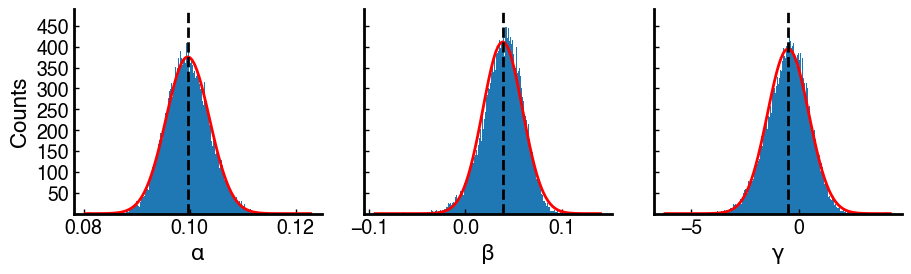

α is 0.0996 with a standard deviation of 0.0041.
β is 0.0385 with a standard deviation of 0.0205.
γ is -0.4941 with a standard deviation of 0.9562.


In [14]:
histoplot(wtnos_output,1000,save=True,fname='full_wt')
# calculated the ∆G based off the coefficients estimated from the distributions
alpha = wtnos_output['alpha'].mean()
beta = wtnos_output['beta'].mean()
gamma = wtnos_output['gamma'].mean()

dGLIE = alpha*data['EEL'] + beta*data['VDW'] + gamma

LIEG = pd.DataFrame({'dGLIE': dGLIE})
# append calculated ∆G to dataframe
data = pd.concat([data,LIEG],axis=1)
print("α is %.4f with a standard deviation of %.4f." % (wtnos_output['alpha'].mean(), wtnos_output['alpha'].std()))
print("β is %.4f with a standard deviation of %.4f." % (wtnos_output['beta'].mean(), wtnos_output['beta'].std()))
print("γ is %.4f with a standard deviation of %.4f." % (wtnos_output['gamma'].mean(), wtnos_output['gamma'].std()))

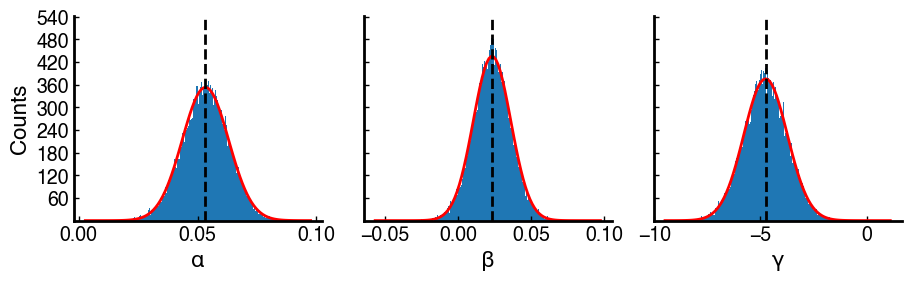


This is compared to the full data set where...
α is 0.0533 with a standard deviation of 0.0097.
β is 0.0232 with a standard deviation of 0.0129.
γ is -4.7579 with a standard deviation of 1.0246.


In [15]:
#nNOS data Bootstrapping 
histoplot(nnos_output,1000,save=True,fname='full_nnos')

print("\nThis is compared to the nNOS data set where...")
print("α is %.4f with a standard deviation of %.4f." % (nnos_output['alpha'].mean(), nnos_output['alpha'].std()))
print("β is %.4f with a standard deviation of %.4f." % (nnos_output['beta'].mean(), nnos_output['beta'].std()))
print("γ is %.4f with a standard deviation of %.4f." % (nnos_output['gamma'].mean(), nnos_output['gamma'].std()))

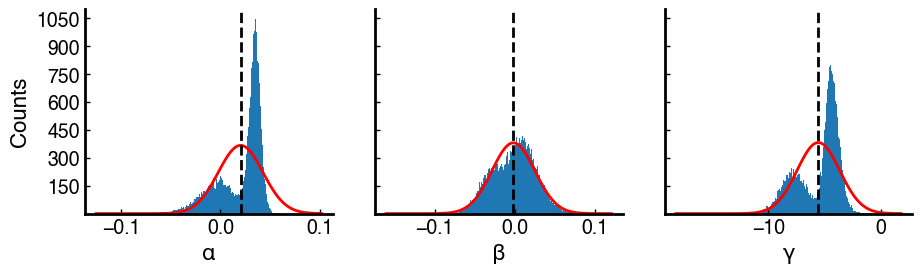

In [16]:
#eNOS data Bootstrapping 
histoplot(enos_output,1000,save=True,fname='full_enos')

### Figure S1 for eNOS

For this eNOS data subset...
α(1) is -0.0039 with a standard deviation of 0.0181.
α(2) is 0.0339 with a standard deviation of 0.0063.
β(1) is -0.0252 with a standard deviation of 0.0160.
β(2) is 0.0082 with a standard deviation of 0.0195.
γ(1) is -7.8225 with a standard deviation of 1.1946.
γ(2) is -4.2864 with a standard deviation of 0.6119.


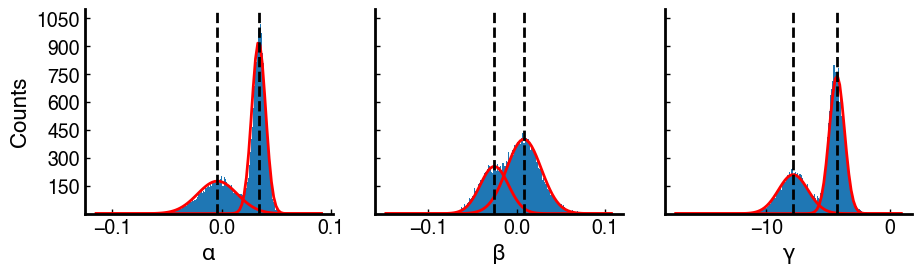

In [65]:
#Due to the bimodal behavior of eNOS data, a manual fitting procedure was done. To be automated later.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
fig.tight_layout()
bins = 1000

print("For this eNOS data subset...")
# Fit and overlay the bimodal distribution on each histogram
for ax, column, name in zip([ax1, ax2, ax3], ['alpha', 'beta', 'gamma'], ['α', 'β', 'γ']):
    enoshist = enos_output[column]
    ax.hist(enoshist, bins=bins, color='k')
    if column == 'alpha':
        # Fit first normal mode
        mean1, std_dev1 = norm.fit(enoshist[enoshist < (enoshist.mean()+0.25*enoshist.mean())])
        x1 = np.linspace(enoshist.min(), enoshist.max(), 100)
        y1 = norm.pdf(x1, mean1, std_dev1)
        
        # Fit second normal mode
        mean2, std_dev2 = norm.fit(enoshist[enoshist >= (enoshist.mean()-0.25*enoshist.mean())])
        x2 = np.linspace(enoshist.min(), enoshist.max(), 100)
        y2 = norm.pdf(x2, mean2, std_dev2)
        print("α(1) is %.4f with a standard deviation of %.4f." % (mean1,std_dev1))
        print("α(2) is %.4f with a standard deviation of %.4f." % (mean2,std_dev2))
        
        # Plot fitted distributions
        ax.plot(x1, (y1 * len(enoshist))/2.6 * np.diff(ax.hist(enoshist, bins=bins,color='C0')[1])[0], color='r', linewidth=2)
        ax.plot(x2, (y2 * len(enoshist))/1.4 * np.diff(ax.hist(enoshist, bins=bins,color='C0')[1])[0], color='r', linewidth=2)
        # Plot means as dashed lines
        ax.axvline(enoshist[enoshist < (enoshist.mean()+0.25*enoshist.mean())].mean(), color='k', linestyle='dashed', linewidth=2)
        ax.axvline(enoshist[enoshist >= (enoshist.mean()-0.25*enoshist.mean())].mean(), color='k', linestyle='dashed', linewidth=2) 
        
    elif column == 'beta':
        # Fit first normal mode
        mean1, std_dev1 = norm.fit(enoshist[enoshist < (enoshist.mean()-0*enoshist.mean())])
        
        x1 = np.linspace(enoshist.min(), enoshist.max(), 100)
        y1 = norm.pdf(x1, mean1, std_dev1)
        
        # Fit second normal mode
        mean2, std_dev2 = norm.fit(enoshist[enoshist >= (enoshist.mean()+12*enoshist.mean())])
        x2 = np.linspace(enoshist.min(), enoshist.max(), 100)
        y2 = norm.pdf(x2, mean2, std_dev2)
        # Plot fitted distributions
        ax.plot(x1, (y1 * len(enoshist))/2.5 * np.diff(ax.hist(enoshist, bins=bins, color='C0')[1])[0], color='r', linewidth=2)
        ax.plot(x2, (y2 * len(enoshist))/1.3 * np.diff(ax.hist(enoshist, bins=bins, color='C0')[1])[0], color='r', linewidth=2)
        # Plot means as dashed lines
        ax.axvline(enoshist[enoshist < (enoshist.mean()-0*enoshist.mean())].mean(), color='k', linestyle='dashed', linewidth=2)
        ax.axvline(enoshist[enoshist >= (enoshist.mean()+12*enoshist.mean())].mean(), color='k', linestyle='dashed', linewidth=2)    
        print("β(1) is %.4f with a standard deviation of %.4f." % (mean1,std_dev1))
        print("β(2) is %.4f with a standard deviation of %.4f." % (mean2,std_dev2))
        
    elif column == 'gamma':
        # Fit first normal mode
        mean1, std_dev1 = norm.fit(enoshist[enoshist < (enoshist.mean()+0.0*enoshist.mean())])
        
        x1 = np.linspace(enoshist.min(), enoshist.max(), 100)
        y1 = norm.pdf(x1, mean1, std_dev1)
        
        # Fit second normal mode
        mean2, std_dev2 = norm.fit(enoshist[enoshist >= (enoshist.mean()+0.0*enoshist.mean())])
        x2 = np.linspace(enoshist.min(), enoshist.max(), 100)
        y2 = norm.pdf(x2, mean2, std_dev2)
        # Plot fitted distributions
        ax.plot(x1, (y1 * len(enoshist))/2.9 * np.diff(ax.hist(enoshist, bins=bins, color='C0')[1])[0], color='r', linewidth=2)
        ax.plot(x2, (y2 * len(enoshist))/1.6 * np.diff(ax.hist(enoshist, bins=bins, color='C0')[1])[0], color='r', linewidth=2)
        # Plot means as dashed lines
        ax.axvline(enoshist[enoshist < (enoshist.mean()+0.0*enoshist.mean())].mean(), color='k', linestyle='dashed', linewidth=2)
        ax.axvline(enoshist[enoshist >= (enoshist.mean()+0.0*enoshist.mean())].mean(), color='k', linestyle='dashed', linewidth=2)    
        print("γ(1) is %.4f with a standard deviation of %.4f." % (mean1,std_dev1))
        print("γ(2) is %.4f with a standard deviation of %.4f." % (mean2,std_dev2))
        
    else:
        # Fit normal distribution
        mean, std_dev = norm.fit(enoshist)
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        y = norm.pdf(x, mean, std_dev)
        
        # Plot fitted distribution
        ax.plot(x, y * len(enoshist) * np.diff(ax.hist(enoshist, bins=bins)[1])[0], color='r', linewidth=2)
    
        # Plot mean as dashed line
        ax.axvline(enoshist.mean(), color='k', linestyle='dashed', linewidth=2)
        print("β is %.4f with a standard deviation of %.4f." % (mean,std_dev))
    
    # Adjust plot aesthetics
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.xaxis.set_tick_params(labelsize=14, width=1, direction='in')
    ax.yaxis.set_tick_params(labelsize=14, width=1, direction='in')
    ax.set_xlabel(name, fontsize=16, fontweight='regular')
    ax.xaxis.label.set_color('k')
    ax.yaxis.label.set_color('k')
    # formatting
    plt.gca().yaxis.set_major_locator(MaxNLocator(prune='lower'))
    plt.subplots_adjust(bottom=0.25)
    if ax == ax1:
        ax.set_ylabel('Counts', fontsize=16, fontweight='regular')
        
        
# Save as PNG
plt.savefig('figure_histoplot_enos2.png', dpi=300)

# Save as SVG
plt.savefig('figure_histoplot_enos2.svg', dpi=300)

plt.show()


### Using the calculated ∆G values from the bootstrapping analysis, perform a linear regression against the experimental ∆Gs

In [18]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dGLIE, dGexp)
dGrange = np.linspace(min(dGLIE)-.1,max(dGLIE)+.1)
linefit = slope*dGrange +intercept
rsq = r_value**2
print("The R\u00b2 for the full NOS data set fit is %.3f. See figure below." % (rsq))

The R² for the full NOS data set fit is 0.878. See figure below.


## Figure 3

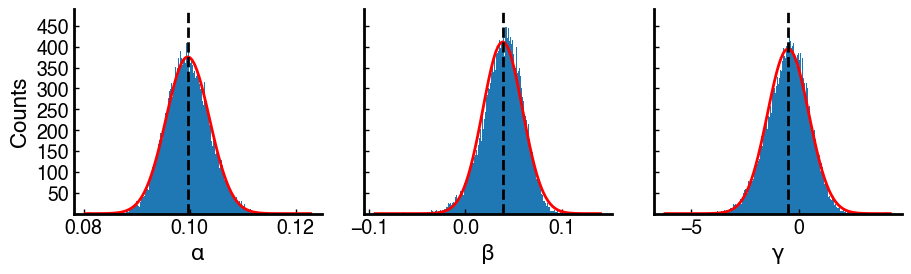

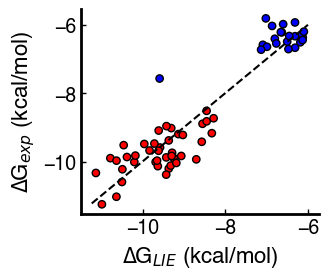

In [19]:
#All WT data Bootstrapping 
histoplot(wtnos_output,1000,save=True,fname='full_wt_3')

nos = np.array(data['Isoform']=='nNOS')
col = np.where(nos,'r','b')

fig ,ax = plt.subplots(1,1,figsize=(3.5,3))
fig.tight_layout()
plt.scatter(dGLIE,dGexp,c=col,s=28,edgecolor='k')
plt.plot(dGrange,linefit,'k--')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.xaxis.set_tick_params(labelsize=14, width=1,direction='in')
ax.yaxis.set_tick_params(labelsize=14, width=1,direction='in')
ax.set_xlabel('∆G$_{LIE}$ (kcal/mol)', fontsize=16, fontweight='regular')
ax.set_ylabel('∆G$_{exp}$ (kcal/mol)', fontsize=16, fontweight='regular')
ax.xaxis.label.set_color('k')
ax.yaxis.label.set_color('k')
plt.subplots_adjust(left=0.25)
plt.subplots_adjust(bottom=0.25)
# Save as PNG
plt.savefig('figure_3b.png', dpi=300)


# Save as SVG
plt.savefig('figure_3b.svg', dpi=300)

In [20]:
data.head()

,LigID,Isoform,Variant,Origin,PDB,EEL_A,EEL_B,EEL,VDW_A,VDW_B,VDW,dGexp,Ki,AltID,Reference,subform,dGLIE
0,JI4,nNOS,WT,rat,3JWS,-68.35,-71.93,-70.140,-45.55,-46.02,-45.785,-9.893899,0.0522,J4,1,nNOS,-9.246057
2,JI4,eNOS,WT,bovine,3JWW,-47.24,-42.15,-44.695,-41.05,-46.43,-43.740,-6.220288,26.4000,J4,1,eNOS,-6.632109
3,J11,nNOS,WT,rat,3JWU,-69.56,-68.21,-68.885,-47.70,-44.56,-46.130,-9.193769,0.1710,J11,1,nNOS,-9.134307
4,J11,eNOS,WT,bovine,3JWY,-38.68,-47.70,-43.190,-48.68,-47.77,-48.225,-6.215835,26.6000,J11,1,eNOS,-6.654931
5,JI5,nNOS,WT,rat,3JWT,-90.62,-89.33,-89.975,-40.16,-39.02,-39.590,-11.243542,0.0053,J5,1,nNOS,-10.983643


### Now let's see how things change where we only include "shared inhibitors" or cases where we have LIEuated ∆G for eNOS and nNOS

In [21]:
# Select the matching inhibitor subset
data_match = data.loc[data.duplicated(subset='LigID', keep=False)]
dGexpM = data_match['dGexp'].to_numpy()

In [22]:
#Perform the same bootstrap analysis
samples = 100000
matchingnos_output,distM = bootstrapper(data_match,data_match.shape[0],samples)

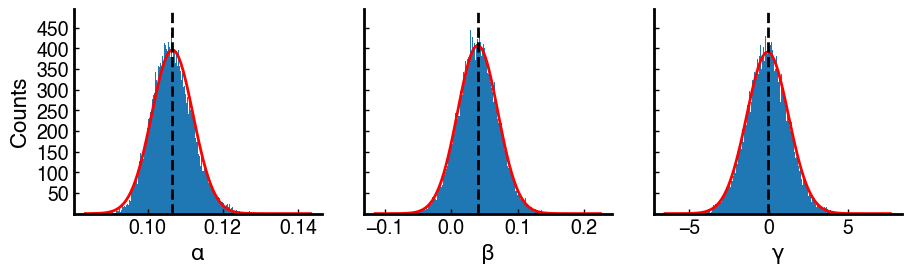

In [24]:
histoplot(matchingnos_output,1000,save=True,fname="matching_wt")

In [25]:
alphaM = matchingnos_output['alpha'].mean()
betaM = matchingnos_output['beta'].mean()
gammaM = matchingnos_output['gamma'].mean()

dGLIEM = alphaM*data_match['EEL'] + betaM*data_match['VDW'] + gammaM
LIEGM = pd.DataFrame({'dGLIEM': dGLIEM})
data_match = pd.concat([data_match,LIEGM],axis=1)

dGLIEM_applied = alphaM*data['EEL'] + betaM*data['VDW'] + gammaM
LIEGM_applied = pd.DataFrame({'dGLIEM_app': dGLIEM_applied})
data_applied = pd.concat([data,LIEGM_applied],axis=1)


print("For this matching data subset...")
print("α is %.4f with a standard deviation of %.4f." % (matchingnos_output['alpha'].mean(), matchingnos_output['alpha'].std()))
print("β is %.4f with a standard deviation of %.4f." % (matchingnos_output['beta'].mean(), matchingnos_output['beta'].std()))
print("γ is %.4f with a standard deviation of %.4f." % (matchingnos_output['gamma'].mean(), matchingnos_output['gamma'].std()))

print("\nThis is compared to the full data set where...")
print("α is %.4f with a standard deviation of %.4f." % (wtnos_output['alpha'].mean(), wtnos_output['alpha'].std()))
print("β is %.4f with a standard deviation of %.4f." % (wtnos_output['beta'].mean(), wtnos_output['beta'].std()))
print("γ is %.4f with a standard deviation of %.4f." % (wtnos_output['gamma'].mean(), wtnos_output['gamma'].std()))

For this matching data subset...
α is 0.1066 with a standard deviation of 0.0055.
β is 0.0399 with a standard deviation of 0.0302.
γ is -0.0674 with a standard deviation of 1.3183.

This is compared to the full data set where...
α is 0.0996 with a standard deviation of 0.0041.
β is 0.0385 with a standard deviation of 0.0205.
γ is -0.4941 with a standard deviation of 0.9562.


In [26]:
# Perform the regression again on the matching data subset
slopeM, interceptM, r_valueM, p_valueM, std_errM = scipy.stats.linregress(dGLIEM, dGexpM)
dGrangeM = np.linspace(min(dGLIEM)-.1,max(dGLIEM)+.1)
linefitM = slopeM*dGrangeM +interceptM
rsqM = r_valueM**2
print("The R\u00b2 for this fit is %.3f. See figure below." % (rsqM))

The R² for this fit is 0.911. See figure below.


### We also want to point out the tightest and weakest binding inhibitors to nNOS data in the matching subset and see where they fall in the eNOS data distribution.

In [27]:
# Filtering data based on condition "Isoform == 'nNOS'"
subset_nnos = data_match[data_match["Isoform"] == "nNOS"]

# Filtering data based on condition "Isoform == 'eNOS'"
subset_enos = data_match[data_match["Isoform"] == "eNOS"]

# Finding the maximum value of 'dGexp' in subset_nnos
nnosmatchmax = subset_nnos[subset_nnos["dGexp"] == subset_nnos["dGexp"].max()]

# Finding the minimum value of 'dGexp' in subset_nnos
nnosmatchmin = subset_nnos[subset_nnos["dGexp"] == subset_nnos["dGexp"].min()]

# Extracting the 'inhibitor' corresponding to the maximum 'dGexp' in subset_nnos
subset_nnos_maxinhibit = nnosmatchmax['LigID'].item()

# Extracting the 'inhibitor' corresponding to the minimum 'dGexp' in subset_nnos
subset_nnos_mininhibit = nnosmatchmin['LigID'].item()

# Filtering subset_enos based on the 'inhibitor' value obtained from subset_nnos_mininhibit
enosmatchmin = subset_enos[subset_enos['LigID'] == subset_nnos_mininhibit]

# Filtering subset_enos based on the 'inhibitor' value obtained from subset_nnos_maxinhibit
enosmatchmax = subset_enos[subset_enos['LigID'] == subset_nnos_maxinhibit]


## Figure 4

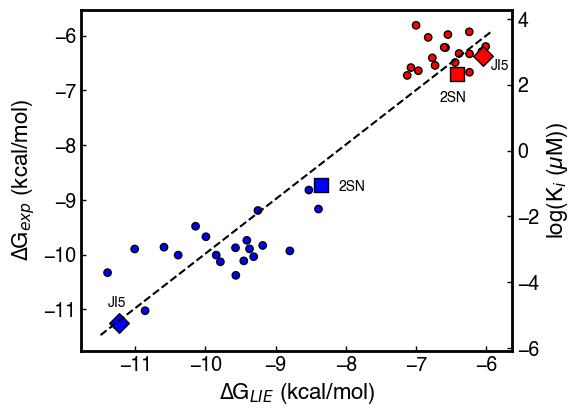

In [51]:
rconst =  0.001985875;
temp = 297.25;
nosM = np.array(data_match['Isoform']=='nNOS')
colM = np.where(nosM,'b','r')
fig ,ax = plt.subplots(1,1,figsize=(5,4))
fig.tight_layout()
plt.plot(dGrangeM,linefitM,'k--')
plt.scatter(dGLIEM,dGexpM,c=colM,s=28,edgecolor='k')
plt.scatter(nnosmatchmin['dGLIEM'].item(),nnosmatchmin['dGexp'].item(),c='b',marker='D',s=100,edgecolor='k')
plt.scatter(nnosmatchmax['dGLIEM'].item(),nnosmatchmax['dGexp'].item(),c='b',marker='s',s=100,edgecolor='k')
plt.scatter(enosmatchmin['dGLIEM'].item(),enosmatchmin['dGexp'].item(),c='r',marker='D',s=100,edgecolor='k')
plt.scatter(enosmatchmax['dGLIEM'].item(),enosmatchmax['dGexp'].item(),c='r',marker='s',s=100,edgecolor='k')
plt.annotate(subset_nnos_mininhibit, (nnosmatchmin['dGLIEM'].item()-.15, nnosmatchmin['dGexp'].item()+0.3))
plt.annotate(subset_nnos_maxinhibit, (nnosmatchmax['dGLIEM'].item()+.25, nnosmatchmax['dGexp'].item()-0.1))
plt.annotate(subset_nnos_mininhibit, (enosmatchmin['dGLIEM'].item()+.1, enosmatchmin['dGexp'].item()-0.25))
plt.annotate(subset_nnos_maxinhibit, (enosmatchmax['dGLIEM'].item()-.25, enosmatchmax['dGexp'].item()-0.50))

ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.xaxis.set_tick_params(labelsize=14, width=1,direction='in')
ax.yaxis.set_tick_params(labelsize=14, width=1,direction='in')
ax.set_xlabel('∆G$_{LIE}$ (kcal/mol)', fontsize=16, fontweight='regular')
ax.set_ylabel('∆G$_{exp}$ (kcal/mol)', fontsize=16, fontweight='regular')
ax.xaxis.label.set_color('k')
ax.yaxis.label.set_color('k')

ax2 = ax.twinx()
ax2.plot(dGrangeM,np.log((np.exp(linefitM/(rconst*temp)))*1e6),'none')
ax2.yaxis.set_tick_params(labelsize=14, width=1,direction='in')
ax2.set_ylabel('log(K$_i$ (µM))', fontsize=16, fontweight='regular')
ax2.yaxis.label.set_color('k')
#plt.autoscale()
#plt.subplots_adjust(left=0.25)
#plt.subplots_adjust(bottom=0.25)
# Save as PNG
plt.savefig('figure_4.png', dpi=300,bbox_inches='tight')

# Save as SVG
plt.savefig('figure_4.svg', dpi=300,bbox_inches='tight')

#### The scatter plot illustrates the comparison between calculated (∆G${LIE}$) and experimental (∆G${exp}$) free energy values for the inhibition of nitric oxide synthase (NOS) isoforms. The data points are color-coded based on the NOS isoform, with blue indicating neuronal NOS (nNOS) and red indicating endothelial NOS (eNOS). Additionally, diamond markers represent the minimum inhibition data points for nNOS and square markers represent the maximum inhibition data points for both nNOS and eNOS. The secondary y-axis shows the corresponding logarithmic inhibition constants (log(K$i$)) calculated from the regression line fitted to the data points. The x-axis denotes the calculated free energy (∆G${LIE}$) in kcal/mol, while the y-axis represents the experimental free energy (∆G$_{exp}$) in kcal/mol. The logarithmic inhibition constants are represented in units of µM. The solid black line represents the regression line fitted to the data points. 

## Below is just saving the data frames to files

In [29]:
data.to_excel('dGLIE_WT.xlsx')

In [30]:
data_match.to_excel('dGLIE_WT_match.xlsx')

In [31]:
data_applied.to_excel('dGLIE_WT_match2.xlsx')

In [32]:
# Generating the data that will be used for creating Table 2 and Table S2 of the Manuscript.

In [33]:
Table_S2 = pd.concat([data['LigID'],data['Isoform'],data['Origin'],data['PDB'],data['EEL'],data['VDW'],data['dGexp'],data['dGLIE'],data_applied['dGLIEM_app']],axis=1)

In [34]:
Table_S2.to_excel('Table_S2.xlsx')